## Probably Distribution of actuator metrics
### Actuator metrics endpoint returns a lot of details on each call and it's hard to make sense of all the details just by looking at the data unless there is a clear anomaly. Like say a response time of 14x in an application where average response time is x. And it's even harder to correlate data just by looking, for example a higher thread count should result in higher memory consumption. To solve this problem we can use multivariate gaussian probabilty distribution.
So the idea is to capture actuator metrics over a long period of time and then identifying the parameters which can be used to identify probability of a single call to actuator metrics. And then analysing these low probability results to find actual anomalies.
Once we have a good number of actual anomalies, we can feed them to a neural network, and then this neural network will be responsible to find out the actual anomalies.

For the purpose of a POC I created a rest endpoint in a spring boot app, which was doing some IO operation and then hit this endpoint with different number of threads via a jmeter script for about 8 hours. And another service kept on hitting the metrics endpoint and kept persisting it in a db. This data is just to show how probability calculations can be done on metrics data and is not a representative of producation data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal
%matplotlib inline

Actuator data collected over time has been added in a csv file, the columns that are flushed to csv file are mem, mem_free, heap_committed, heap_init, heap_used, heap, nonheap_committed, nonheap_init, nonheap_used, threads_peak, threads_total_started, threads, classes, classes_loaded, gc_ps_scavenge_count, gc_ps_scavenge_time, gc_ps_marksweep_count, gc_ps_marksweep_time, gauge_response_test. Here we have excluded columns which are linearly increasing or which are constant like application uptime or available memory etc. 
Lets load this data in a numpy array.

In [210]:
X = np.genfromtxt ('ActuatorData.csv', delimiter=",", dtype=int)
print(X[0,0])
print (X.shape)

263693
(776, 19)


One of the important things to consider while using multivariate or regular Gaussian anomaly detection is to make sure that we are using data points which roughly follow Gaussian/Normal distribution, i.e. mean value will have the maximum occurences and than occurences will be gradually decreasing on the left and right of mean. Generally when huge amount of data is collected, a lot of datapoints tend to follow Normal distrbution because of Central limit theorem. And if a datapoint is not following Gaussian distribution we can use varios techniques like taking logarithmic to make that datapoint Gaussian. But for the purpose of this study we are only going to take datapoints which are already approximately Gaussain. Lets take a look at certain datapoints by plotting a histogram.

(array([ 55., 161., 212., 180.,  81.,  43.,  24.,   9.,   2.,   2.,   0.,
          1.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([136164. , 145140.3, 154116.6, 163092.9, 172069.2, 181045.5,
        190021.8, 198998.1, 207974.4, 216950.7, 225927. , 234903.3,
        243879.6, 252855.9, 261832.2, 270808.5, 279784.8, 288761.1,
        297737.4, 306713.7, 315690. , 324666.3, 333642.6, 342618.9,
        351595.2, 360571.5, 369547.8, 378524.1, 387500.4, 396476.7,
        405453. ]),
 <a list of 30 Patch objects>)

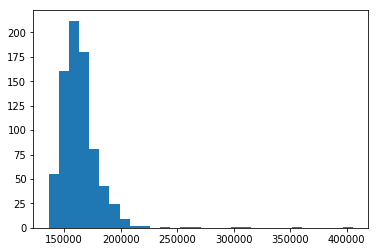

In [3]:
# plotting histogram for memory
plt.hist(X[:,0], bins=30)

(array([11., 19., 26., 37., 56., 49., 73., 85., 47., 64., 48., 70., 64.,
        34., 26., 23., 10., 14.,  4.,  3.,  5.,  2.,  1.,  1.,  0.,  1.,
         1.,  0.,  0.,  2.]),
 array([  1532.,   6016.,  10500.,  14984.,  19468.,  23952.,  28436.,
         32920.,  37404.,  41888.,  46372.,  50856.,  55340.,  59824.,
         64308.,  68792.,  73276.,  77760.,  82244.,  86728.,  91212.,
         95696., 100180., 104664., 109148., 113632., 118116., 122600.,
        127084., 131568., 136052.]),
 <a list of 30 Patch objects>)

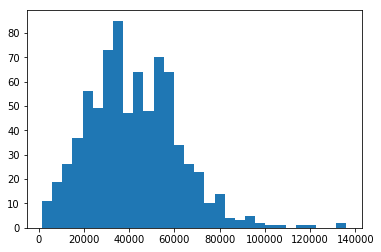

In [4]:
# plotting hist for mem_free
plt.hist(X[:,1], bins=30)

Above distribution is still not a very good Gaussian distribution but considering the fact that data is generated by a load simulation instead of actual prod data, we are going to consider this data point.

(array([ 55., 155., 226., 172.,  84.,  40.,  25.,   8.,   2.,   2.,   0.,
          1.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 79360.,  88320.,  97280., 106240., 115200., 124160., 133120.,
        142080., 151040., 160000., 168960., 177920., 186880., 195840.,
        204800., 213760., 222720., 231680., 240640., 249600., 258560.,
        267520., 276480., 285440., 294400., 303360., 312320., 321280.,
        330240., 339200., 348160.]),
 <a list of 30 Patch objects>)

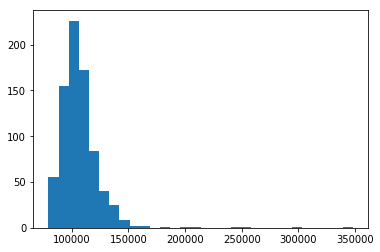

In [5]:
#heap_committed
plt.hist(X[:,2], bins=30)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 776.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([65535.5       , 65535.53333333, 65535.56666667, 65535.6       ,
        65535.63333333, 65535.66666667, 65535.7       , 65535.73333333,
        65535.76666667, 65535.8       , 65535.83333333, 65535.86666667,
        65535.9       , 65535.93333333, 65535.96666667, 65536.        ,
        65536.03333333, 65536.06666667, 65536.1       , 65536.13333333,
        65536.16666667, 65536.2       , 65536.23333333, 65536.26666667,
        65536.3       , 65536.33333333, 65536.36666667, 65536.4       ,
        65536.43333333, 65536.46666667, 65536.5       ]),
 <a list of 30 Patch objects>)

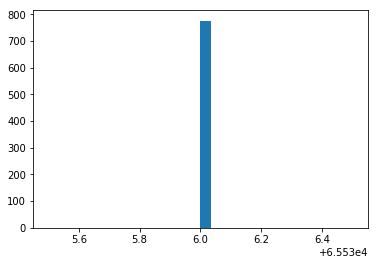

In [6]:
#heap_init
plt.hist(X[:,3], bins=30)

This is a constant, we are not going to consider this in probability calculations.

(array([ 6., 25., 74., 74., 98., 94., 87., 99., 73., 49., 38., 18., 18.,
        10.,  2.,  6.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  2.]),
 array([ 23357. ,  29801.4,  36245.8,  42690.2,  49134.6,  55579. ,
         62023.4,  68467.8,  74912.2,  81356.6,  87801. ,  94245.4,
        100689.8, 107134.2, 113578.6, 120023. , 126467.4, 132911.8,
        139356.2, 145800.6, 152245. , 158689.4, 165133.8, 171578.2,
        178022.6, 184467. , 190911.4, 197355.8, 203800.2, 210244.6,
        216689. ]),
 <a list of 30 Patch objects>)

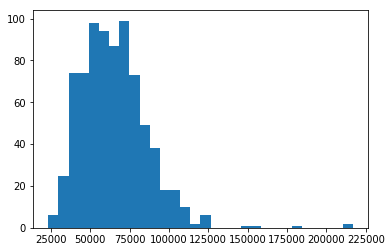

In [7]:
#heap_used
plt.hist(X[:,4], bins=30)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 776.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([913919.5       , 913919.53333333, 913919.56666667, 913919.6       ,
        913919.63333333, 913919.66666667, 913919.7       , 913919.73333333,
        913919.76666667, 913919.8       , 913919.83333333, 913919.86666667,
        913919.9       , 913919.93333333, 913919.96666667, 913920.        ,
        913920.03333333, 913920.06666667, 913920.1       , 913920.13333333,
        913920.16666667, 913920.2       , 913920.23333333, 913920.26666667,
        913920.3       , 913920.33333333, 913920.36666667, 913920.4       ,
        913920.43333333, 913920.46666667, 913920.5       ]),
 <a list of 30 Patch objects>)

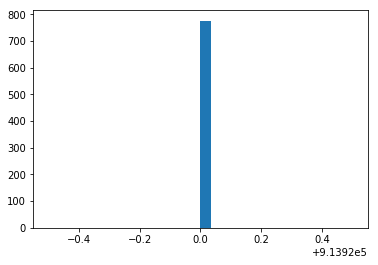

In [10]:
#heap
plt.hist(X[:,5], bins=30)

(array([  1.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,
          0.,  20.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,
        481.,   0.,   0.,   0.,   0.,   0.,   0., 264.]),
 array([60032.        , 60065.33333333, 60098.66666667, 60132.        ,
        60165.33333333, 60198.66666667, 60232.        , 60265.33333333,
        60298.66666667, 60332.        , 60365.33333333, 60398.66666667,
        60432.        , 60465.33333333, 60498.66666667, 60532.        ,
        60565.33333333, 60598.66666667, 60632.        , 60665.33333333,
        60698.66666667, 60732.        , 60765.33333333, 60798.66666667,
        60832.        , 60865.33333333, 60898.66666667, 60932.        ,
        60965.33333333, 60998.66666667, 61032.        ]),
 <a list of 30 Patch objects>)

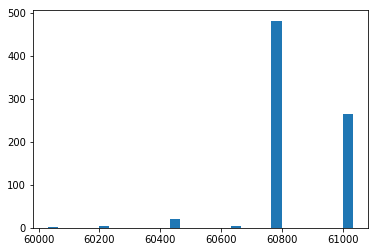

In [11]:
#nonheap_committed
plt.hist(X[:,6], bins=30)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 776.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([2495.5       , 2495.53333333, 2495.56666667, 2495.6       ,
        2495.63333333, 2495.66666667, 2495.7       , 2495.73333333,
        2495.76666667, 2495.8       , 2495.83333333, 2495.86666667,
        2495.9       , 2495.93333333, 2495.96666667, 2496.        ,
        2496.03333333, 2496.06666667, 2496.1       , 2496.13333333,
        2496.16666667, 2496.2       , 2496.23333333, 2496.26666667,
        2496.3       , 2496.33333333, 2496.36666667, 2496.4       ,
        2496.43333333, 2496.46666667, 2496.5       ]),
 <a list of 30 Patch objects>)

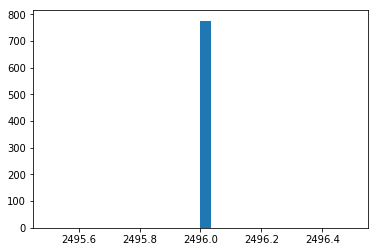

In [12]:
#nonheap_committed
plt.hist(X[:,7], bins=30)

(array([ 12.,  45.,  17.,  69.,  57.,  15.,  42.,  40.,  12.,  69.,  88.,
         55., 250.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([56543. , 56604.3, 56665.6, 56726.9, 56788.2, 56849.5, 56910.8,
        56972.1, 57033.4, 57094.7, 57156. , 57217.3, 57278.6, 57339.9,
        57401.2, 57462.5, 57523.8, 57585.1, 57646.4, 57707.7, 57769. ,
        57830.3, 57891.6, 57952.9, 58014.2, 58075.5, 58136.8, 58198.1,
        58259.4, 58320.7, 58382. ]),
 <a list of 30 Patch objects>)

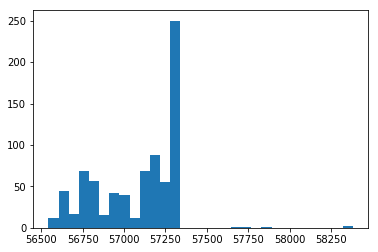

In [16]:
#nonheap_committed
plt.hist(X[:,8], bins=30)

(array([ 29.,   0.,   0.,   0.,   0.,   1.,   6.,  50.,   0.,  23.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
        119.,   0.,   0.,   0.,   0.,   0.,   0., 547.]),
 array([37. , 38.6, 40.2, 41.8, 43.4, 45. , 46.6, 48.2, 49.8, 51.4, 53. ,
        54.6, 56.2, 57.8, 59.4, 61. , 62.6, 64.2, 65.8, 67.4, 69. , 70.6,
        72.2, 73.8, 75.4, 77. , 78.6, 80.2, 81.8, 83.4, 85. ]),
 <a list of 30 Patch objects>)

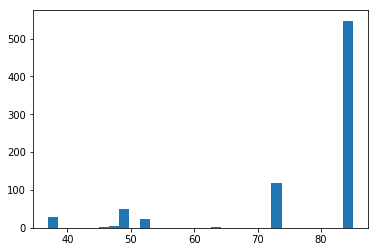

In [17]:
#nonheap_committed
plt.hist(X[:,9], bins=30)

(array([ 29.,   0.,   0.,   0.,   1.,   6.,  50.,   0.,  23.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0., 119.,   0.,
          0.,   0.,   0.,   0.,   0., 205.,   0., 342.]),
 array([42.        , 43.76666667, 45.53333333, 47.3       , 49.06666667,
        50.83333333, 52.6       , 54.36666667, 56.13333333, 57.9       ,
        59.66666667, 61.43333333, 63.2       , 64.96666667, 66.73333333,
        68.5       , 70.26666667, 72.03333333, 73.8       , 75.56666667,
        77.33333333, 79.1       , 80.86666667, 82.63333333, 84.4       ,
        86.16666667, 87.93333333, 89.7       , 91.46666667, 93.23333333,
        95.        ]),
 <a list of 30 Patch objects>)

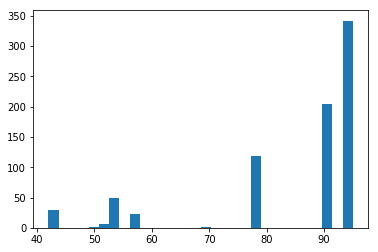

In [18]:
#nonheap_committed
plt.hist(X[:,10], bins=30)

(array([  1.,   0.,   0.,   0.,   0., 740.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,  35.]),
 array([6202., 6204., 6206., 6208., 6210., 6212., 6214., 6216., 6218.,
        6220., 6222., 6224., 6226., 6228., 6230., 6232., 6234., 6236.,
        6238., 6240., 6242., 6244., 6246., 6248., 6250., 6252., 6254.,
        6256., 6258., 6260., 6262.]),
 <a list of 30 Patch objects>)

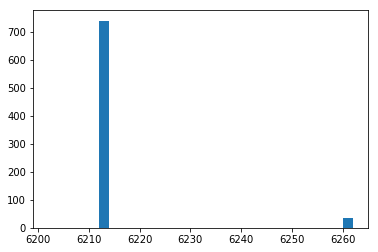

In [19]:
#nonheap_committed
plt.hist(X[:,12], bins=30)

(array([64., 41., 19., 25., 16., 22., 15., 18., 24., 46., 36., 29., 22.,
        28., 23., 22., 22., 16., 23., 18., 21., 23., 30., 25., 30., 32.,
        37., 11., 14., 24.]),
 array([  1.        ,   5.53333333,  10.06666667,  14.6       ,
         19.13333333,  23.66666667,  28.2       ,  32.73333333,
         37.26666667,  41.8       ,  46.33333333,  50.86666667,
         55.4       ,  59.93333333,  64.46666667,  69.        ,
         73.53333333,  78.06666667,  82.6       ,  87.13333333,
         91.66666667,  96.2       , 100.73333333, 105.26666667,
        109.8       , 114.33333333, 118.86666667, 123.4       ,
        127.93333333, 132.46666667, 137.        ]),
 <a list of 30 Patch objects>)

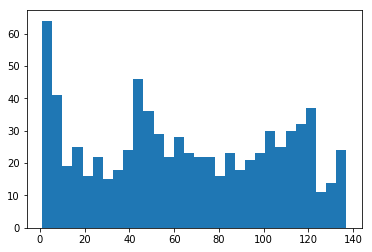

In [23]:
#nonheap_committed
plt.hist(X[:,16], bins=30)

(array([ 47.,  76.,  94.,  94., 140., 132.,  84.,  66.,  17.,  13.,   4.,
          2.,   1.,   2.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.        ,  11.53333333,  23.06666667,  34.6       ,
         46.13333333,  57.66666667,  69.2       ,  80.73333333,
         92.26666667, 103.8       , 115.33333333, 126.86666667,
        138.4       , 149.93333333, 161.46666667, 173.        ,
        184.53333333, 196.06666667, 207.6       , 219.13333333,
        230.66666667, 242.2       , 253.73333333, 265.26666667,
        276.8       , 288.33333333, 299.86666667, 311.4       ,
        322.93333333, 334.46666667, 346.        ]),
 <a list of 30 Patch objects>)

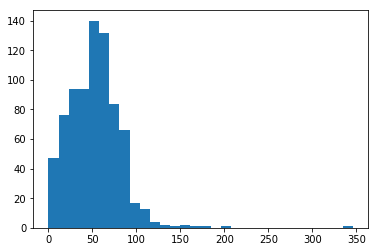

In [27]:
#nonheap_committed
plt.hist(X[:,18], bins=30)

In [110]:
Z = X[:,0:3]
U = np.zeros((776,1), dtype=int)
U[:,0] =  X[:,4]
Z = np.append(Z, U, axis=1)
U[:,0] =  X[:,18]
Z = np.append(Z, U, axis=1)
print (Z[0,:])
print (Z.shape)

[263693 119984 205312  85327     69]
(776, 5)


For calculating probability of a data row(an actuator instance) we have two methods.
1) Probability of a given mem_free will be 
(1/√2*√Π*σ)*e^(-(x-μ)/(2*σ^2)) 
where x is mem_free, μ is mean of all mem_free values, and σ is variance.
So to calculate probability of a given actuator metrics result we will need P(mem_free)*P(heap_used)*...*P(response).
The problem with this method is it does not consider relation between multiple variables.
Hence we are going to use multivariate normal distribution
P(actuator result) = (1/((2Π)^n/2)*|∑|)*e^(-.5*(x-μ)′*∑^-1*(x-μ))
where ∑ = covariance matrix, |∑| = detrminant of covariance matrix, μ= vector with all means for all datapoints, n= number of datapoints(in our case 5)
Lets write methods to calculate mean, variance, covariance matrix and probability.

In [29]:
def getMeanAndVariance(X):
    (m,n) = X.shape
    # initializing mu(mean) and sigma2(variance)
    mu = np.zeros((n,1))
    sigma2 = np.zeros((n,1))
    # mean
    mu = np.sum(X, axis=0)/m
    tempSigma = X - mu
    tempSigma2 = np.power(tempSigma, 2)
    sigma2 = np.sum(tempSigma2, axis=0)/m
    return (mu, sigma2)

In [30]:
def getCovariance(X):
    return np.cov(X, rowvar=False)

In [36]:
def calculateProbabilities(X, mean, cov):
    # var = multivariate_normal(mean, cov, allow_singular=True)
    var = multivariate_normal(mean, cov)
    p = np.zeros((len(X),1))
    for i in range(len(X)):
        p[i] = var.pdf(X[i])
    return p

Let's calulate probability for all entries.

In [ ]:
(mean, var1) = getMeanAndVariance(Z)
cov = getCovariance(Z)
p = calculateProbabilities(Z, mean, cov)
# print (mean)
# print (cov)
# print (p.size)
p_sort = np.sort(p, axis=0)
Y = np.zeros((776,1), dtype=int)
for i in range(len(X)):
    if (p[i]<=p_sort[60,0]):
        Y[i] = 1

Now with probabilities, we can check the actuator data with low probabilities, we can check application logs around the times when probavility is low and can actually analyse why we have reached to a low probability instance, whether this instacne is actually an anomaly or not. Anomalies can be of various types, for example high response time, despite low active threads or low memory consumption and they might be quite hard to found directly. 

Once we have found enough anomalies, say a 1000, for a production system, we can follow either of the below two approaches

1) We can revisit and calculate a threshhold probability below which an instance is anomaly and above which instance is regular and system is working fine. And then whenever we find an instance with probability lower than the threshhold we can cosider it as an anomaly.
2) We can feed the data to a classification algorithm like logistic regression, SVM or a neural netwrok

For the purpose of this POC I am going to pick 60 instances(approx 10%) with lowest probabilities and consider them as anomalies. This is just for POC, in an actual production system, much less than 1% instances will be actual anomalies.

After getting sufficient anomalies, we can also run the data through a neural network to generate an algorithm to find anomalies.

Let's create a new array Y, which will be the labels for supervised learning algorithm. Here I am marking low probability instances as 1, and high probability instances as 0. 

In [ ]:
Below is a sample neural network implementation based on Keras library provided by tensorflow. 

In [179]:
import tensorflow as tf
from tensorflow import keras

In [202]:
model = keras.Sequential([
    # keras.layers.Dense(105, input_shape=(19,), activation=tf.nn.relu), #this row can be trained when we are training whole data
    keras.layers.Dense(105, input_shape=(5,), activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [203]:
model.compile(optimizer='sgd', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [204]:
model.fit(Z, Y, epochs=5)

Epoch 1/5
776/776 [==============================] - 2s 3ms/step - loss: 4.2624 - acc: 0.7332
Epoch 2/5
776/776 [==============================] - 0s 92us/step - loss: 1.2670 - acc: 0.9214
Epoch 3/5
776/776 [==============================] - 0s 105us/step - loss: 1.2670 - acc: 0.9214
Epoch 4/5
776/776 [==============================] - 0s 103us/step - loss: 1.2670 - acc: 0.9214
Epoch 5/5
776/776 [==============================] - 0s 114us/step - loss: 1.2670 - acc: 0.9214


In [208]:
new_ac_instance = np.ones((1,5))
prediction = model.predict(new_ac_instance)
print (prediction)

[[0.]]


You can see above we have achieved 92% accuracy, which is a terrible accuracy for the given system. Rather for such kind of problems where labels with value 1 which be much lower than labels with value 0, accuracy alone is not a good performance parameter, we have to consider precision, recall and F1 score etc.

Also above neural network is just a basic implementation, after getting sufficient data, we will have to optimize it on the basis of bias and overfitting. We might need to add regularization as well.